# Brain Tumor Segmentation with Transfer Learning

## Using EfficientNetB3 as a Backbone with U-Net

-  **EfficientNetB3** pretrained on ImageNet
-  **Loss Functions** (Weighted CE + Dice + Focal)


#  **1-** **Environment Preparation**

In [1]:
import sys
IS_COLAB = 'google.colab' in sys.modules

if IS_COLAB:
    print("Running on Google Colab!")
    from google.colab import drive
    drive.mount('/content/drive')

    import os
    os.chdir('/content/drive/MyDrive')
else:
    print("Running locally")

Running on Google Colab!
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **2-** **Import libraries**

In [2]:
import os
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import EfficientNetB3, ResNet50

# Check for pycocotools (for RLE segmentation support)
try:
    from pycocotools import mask as maskUtils
    HAVE_PYCOCO = True
except ImportError:
    HAVE_PYCOCO = False
    print("pycocotools not available - RLE segmentation will not be supported")



##  Path Preparation

In [3]:
DRIVE_PROJECT = 'image_segmentation_project'
DATA_ROOT = Path(f'/content/drive/MyDrive/{DRIVE_PROJECT}/data')
OUT_ROOT = Path(f'/content/drive/MyDrive/{DRIVE_PROJECT}/data_masks')

print(f"Data root: {DATA_ROOT}")
print(f"Masks root: {OUT_ROOT}")

Data root: /content/drive/MyDrive/image_segmentation_project/data
Masks root: /content/drive/MyDrive/image_segmentation_project/data_masks


## check COCO Annotations
### read Annotations files to train

In [4]:
ann_file = DATA_ROOT / 'train' / '_annotations.coco.json'

if ann_file.exists():
    with open(ann_file, 'r', encoding='utf-8') as f:
        coco_data = json.load(f)

    # Categories
    categories = coco_data.get('categories', [])
    print(f"Number of Categories: {len(categories)}")
    for cat in categories:
        print(f"ID: {cat['id']}, Name: {cat.get('name', 'N/A')}")

    # Images
    images = coco_data.get('images', [])
    print(f"\nNumber of Images: {len(images)}")

    # Annotations
    annotations = coco_data.get('annotations', [])
    print(f"\nNumber of Annotations: {len(annotations)}")

    # Check the fisrt segmentation
    if annotations:
        sample_ann = annotations[0]
        print(f"- annotation_id: {sample_ann.get('id')}")
        print(f"- image_id: {sample_ann.get('image_id')}")
        print(f"- category_id: {sample_ann.get('category_id')}")
        print(f"- bbox: {sample_ann.get('bbox')}")
        seg = sample_ann.get('segmentation', [])
        if isinstance(seg, list) and seg:
            print(f"segmentation type: polygon")

else:
    print(f"annotation doesn't exist in: {ann_file}")

Number of Categories: 3
ID: 0, Name: Tumor
ID: 1, Name: 0
ID: 2, Name: 1

Number of Images: 1502

Number of Annotations: 1502
- annotation_id: 0
- image_id: 0
- category_id: 1
- bbox: [145, 239, 168.75, 162.5]
segmentation type: polygon


# **3-** **Generating Masks from COCO Annotations**

In [5]:
import shutil

# Helper functions
def seg_to_mask(seg, height, width):
    """Convert a COCO segmentation to a binary mask of shape (height, width).
    Supports polygons (list of lists) and RLE (encoded dict) when pycocotools is available.
    """
    if isinstance(seg, list):
        # polygons: seg is a list of lists, each list is [x1,y1,x2,y2,...]
        mask = np.zeros((height, width), dtype=np.uint8)
        for poly in seg:
            if len(poly) < 6:
                continue
            pts = np.array(poly, dtype=np.int32).reshape(-1, 2)
            # Clip points to image bounds to be safe
            pts[:,0] = np.clip(pts[:,0], 0, width-1)
            pts[:,1] = np.clip(pts[:,1], 0, height-1)
            cv2.fillPoly(mask, [pts], 1)
        return mask
    elif isinstance(seg, dict) or (hasattr(seg, 'get') and 'counts' in seg):
        # RLE format (pycocotools required)
        if not HAVE_PYCOCO:
            raise RuntimeError('RLE segmentation encountered but pycocotools is not available.')
        decoded = maskUtils.decode(seg)  # returns HxW or HxW x1
        if decoded.ndim == 3:
            decoded = decoded[:,:,0]
        return (decoded.astype(np.uint8) > 0).astype(np.uint8)
    else:
        # Unknown format
        raise ValueError('Unknown segmentation format!!')

def ann_to_mask(ann, height, width):
    """Create binary mask for a single annotation dict"""
    seg = ann.get('segmentation', None)
    if seg is None:
        return np.zeros((height, width), dtype=np.uint8)
    return seg_to_mask(seg, height, width)

def process_split(split_name, data_root, out_root):
    """Process a split and generate masks from COCO annotations"""
    ann_file = data_root / split_name / '_annotations.coco.json'
    if not ann_file.exists():
        print(f'Annotations not found for split {split_name}: {ann_file} — skipping')
        return 0

    print(f'\nProcessing split: {split_name}')
    with open(ann_file, 'r', encoding='utf-8') as f:
        coco = json.load(f)

    images = coco.get('images', [])
    annotations = coco.get('annotations', [])
    categories = coco.get('categories', [])

    # Use the original category_id directly
    cat_id_to_idx = {}
    for cat in categories:
        cat_id_to_idx[cat['id']] = cat['id']

    # Counting the number of categories (top ID + 1) to include background
    num_classes = max(cat_id_to_idx.values()) + 1 if cat_id_to_idx else 1

    print(f'  Found {len(images)} images, {len(annotations)} annotations')
    print(f'  Categories: {[(c["id"], c.get("name", "unnamed")) for c in categories]}')
    print(f'  Total classes (including background): {num_classes}')

    # group annotations by image_id
    anns_by_img = {}
    for ann in annotations:
        img_id = ann['image_id']
        anns_by_img.setdefault(img_id, []).append(ann)

    out_split_dir = out_root / split_name
    out_split_dir.mkdir(parents=True, exist_ok=True)

    skipped = 0
    saved = 0

    for img in tqdm(images, desc=f'Processing {split_name} images'):
        img_id = img.get('id')
        file_name = img.get('file_name')
        height = img.get('height')
        width = img.get('width')

        if not file_name or height is None or width is None:
            skipped += 1
            continue

        final_mask = np.zeros((height, width), dtype=np.uint8)
        anns = anns_by_img.get(img_id, [])

        # draw larger annotations first so they take precedence
        anns_sorted = sorted(anns, key=lambda a: a.get('area', 0), reverse=True)

        for ann in anns_sorted:
            try:
                m = ann_to_mask(ann, height, width)
            except Exception as e:
                continue
            cat_idx = cat_id_to_idx.get(ann.get('category_id'), 0)
            if cat_idx == 0:
                continue
            mask_positions = (m > 0) & (final_mask == 0)
            final_mask[mask_positions] = cat_idx

        # Save mask as PNG
        if num_classes > 255:
            out_name = Path(file_name).stem + '_mask.npy'
            out_path = out_split_dir / out_name
            np.save(str(out_path), final_mask)
        else:
            out_name = Path(file_name).stem + '_mask.png'
            out_path = out_split_dir / out_name
            cv2.imwrite(str(out_path), final_mask)
        saved += 1

    print(f'Saved masks: {saved}, skipped: {skipped}')
    return num_classes

# Delete and regenerate old masks
if OUT_ROOT.exists():
    print(f"\nDelete old masks from: {OUT_ROOT}...")
    shutil.rmtree(OUT_ROOT)
    print("Deleted!")

# Creating new folders
OUT_ROOT.mkdir(parents=True, exist_ok=True)
for split in ['train', 'valid', 'test']:
    (OUT_ROOT / split).mkdir(parents=True, exist_ok=True)

print(f"The new masks folders were created in :{OUT_ROOT}")

# Generate masks
num_classes_detected = 1
for split in ['train', 'valid', 'test']:
    nc = process_split(split, DATA_ROOT, OUT_ROOT)
    if nc:
        num_classes_detected = max(num_classes_detected, nc)

print(f"\nDone...")
print(f"Number of categories: {num_classes_detected}")


Delete old masks from: /content/drive/MyDrive/image_segmentation_project/data_masks...
Deleted!
The new masks folders were created in :/content/drive/MyDrive/image_segmentation_project/data_masks

Processing split: train
  Found 1502 images, 1502 annotations
  Categories: [(0, 'Tumor'), (1, '0'), (2, '1')]
  Total classes (including background): 3


Processing train images: 100%|██████████| 1502/1502 [00:12<00:00, 120.46it/s]


Saved masks: 1502, skipped: 0

Processing split: valid
  Found 429 images, 429 annotations
  Categories: [(0, 'Tumor'), (1, '0'), (2, '1')]
  Total classes (including background): 3


Processing valid images: 100%|██████████| 429/429 [00:03<00:00, 131.68it/s]


Saved masks: 429, skipped: 0

Processing split: test
  Found 215 images, 215 annotations
  Categories: [(0, 'Tumor'), (1, '0'), (2, '1')]
  Total classes (including background): 3


Processing test images: 100%|██████████| 215/215 [00:01<00:00, 132.10it/s]

Saved masks: 215, skipped: 0

Done...
Number of categories: 3


### -Loading data using Data Generator (to prevent crashes)
### -Enable Mixed Precision (reduces VRAM consumption by 50%)

In [6]:
import gc
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications.efficientnet import preprocess_input

IMG_SIZE = (256, 256)
BACKBONE = 'efficientnetb3'
BATCH_SIZE = 16

policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)
print(f"Mixed Precision enabled: {policy.name}")
print(f"Compute dtype: {policy.compute_dtype}")
print(f"Variable dtype: {policy.variable_dtype}")

Mixed Precision enabled: mixed_float16
Compute dtype: float16
Variable dtype: float32


### Data Generator Class

In [7]:
class SegmentationDataGenerator(Sequence):
    """
    Generator load image batch-by-batch
   instead of loading all image at once in RAM
    """
    def __init__(self, img_dir, mask_dir, img_size=(256, 256), batch_size=8,
                 augment=False, preprocess_fn=None):
        self.img_dir = Path(img_dir)
        self.mask_dir = Path(mask_dir)
        self.img_size = img_size
        self.batch_size = batch_size
        self.augment = augment
        self.preprocess_fn = preprocess_fn

        self.image_files = []
        all_images = [f for f in os.listdir(self.img_dir)
                      if f.lower().endswith((".jpg", ".jpeg", ".png"))
                      and not f.endswith('_mask.png')]

        for fn in all_images:
            mask_path = self.mask_dir / (Path(fn).stem + "_mask.png")
            if mask_path.exists():
                self.image_files.append(fn)

        self.indexes = np.arange(len(self.image_files))
        if self.augment:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.ceil(len(self.image_files) / self.batch_size))

    def __getitem__(self, idx):
        batch_indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_files = [self.image_files[i] for i in batch_indexes]

        X_batch = []
        Y_batch = []

        for fn in batch_files:
            img_path = self.img_dir / fn
            mask_path = self.mask_dir / (Path(fn).stem + "_mask.png")

            # Read mask
            img = cv2.imread(str(img_path))
            mask = cv2.imread(str(mask_path), cv2.IMREAD_UNCHANGED)

            if img is None or mask is None:
                continue

            # Resize
            img_r = cv2.resize(img, self.img_size, interpolation=cv2.INTER_AREA)
            mask_r = cv2.resize(mask, self.img_size, interpolation=cv2.INTER_NEAREST)

            # BGR -> RGB
            img_r = cv2.cvtColor(img_r, cv2.COLOR_BGR2RGB).astype(np.float32)

            # Apply EfficientNet preprocessing
            if self.preprocess_fn:
                img_r = self.preprocess_fn(img_r)

            if mask_r.ndim == 3:
                mask_r = mask_r[..., 0]
            mask_r = mask_r.astype(np.int32)[..., np.newaxis]

            # Augmentation
            if self.augment:
                img_r, mask_r = self._augment(img_r, mask_r)

            X_batch.append(img_r)
            Y_batch.append(mask_r)

        return np.array(X_batch, dtype=np.float32), np.array(Y_batch, dtype=np.int32)

    def _augment(self, image, mask):
        """Simple augmentation"""
        # Random horizontal flip
        if np.random.random() > 0.5:
            image = np.fliplr(image)
            mask = np.fliplr(mask)

        # Random vertical flip
        if np.random.random() > 0.5:
            image = np.flipud(image)
            mask = np.flipud(mask)

        # Random 90-degree rotation
        k = np.random.randint(0, 4)
        image = np.rot90(image, k)
        mask = np.rot90(mask, k)

        return image, mask

    def on_epoch_end(self):
        if self.augment:
            np.random.shuffle(self.indexes)

# Generators
train_gen = SegmentationDataGenerator(
    img_dir=DATA_ROOT / 'train',
    mask_dir=OUT_ROOT / 'train',
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    augment=True,
    preprocess_fn=preprocess_input
)

In [8]:
val_gen = SegmentationDataGenerator(
    img_dir=DATA_ROOT / 'valid',
    mask_dir=OUT_ROOT / 'valid',
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    augment=False,
    preprocess_fn=preprocess_input
)

test_gen = SegmentationDataGenerator(
    img_dir=DATA_ROOT / 'test',
    mask_dir=OUT_ROOT / 'test',
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    augment=False,
    preprocess_fn=preprocess_input
)

print(f"\nData Generators created:")
print(f"Train: {len(train_gen)} batches ({len(train_gen.image_files)} images)")
print(f"Valid: {len(val_gen)} batches ({len(val_gen.image_files)} images)")
print(f"Test:  {len(test_gen)} batches ({len(test_gen.image_files)} images)")
print(f"Batch Size: {BATCH_SIZE}")


Data Generators created:
Train: 94 batches (1502 images)
Valid: 27 batches (429 images)
Test:  14 batches (215 images)
Batch Size: 16


In [9]:
max_class = 0
for i in range(min(3, len(train_gen))):
    _, Y_batch = train_gen[i]
    max_class = max(max_class, Y_batch.max())

num_classes = int(max_class) + 1
print(f"Number of classes detected: {num_classes}")


Number of classes detected: 3


In [10]:
# Memory cleaning
gc.collect()

0

# **4-** **Class distribution analysis**

Sampling 10 batches for class distribution...
  Class 0: 10,099,005 pixels (96.31%)
  Class 1: 263,362 pixels (2.51%)
  Class 2: 123,393 pixels (1.18%)


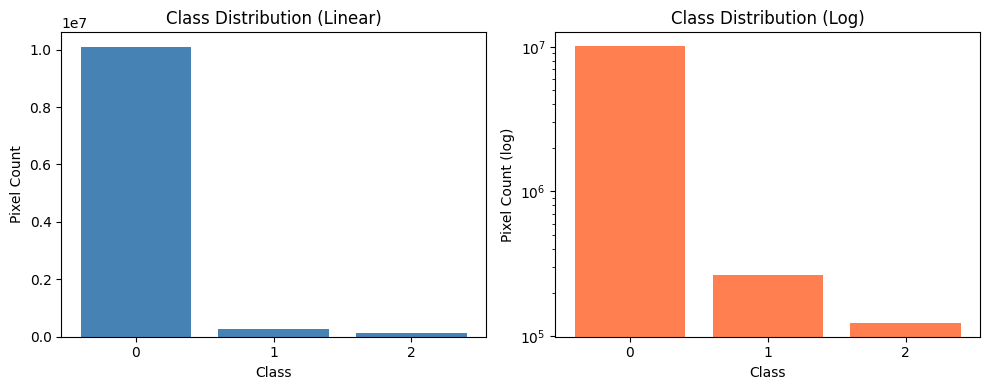

13950

In [11]:
# collect batches
class_counts = np.zeros(num_classes, dtype=np.int64)
n_batches_to_sample = min(10, len(train_gen))

print(f"Sampling {n_batches_to_sample} batches for class distribution...")
for i in range(n_batches_to_sample):
    _, Y_batch = train_gen[i]
    for c in range(num_classes):
        class_counts[c] += np.sum(Y_batch == c)

total = class_counts.sum()

for cls, cnt in enumerate(class_counts):
    pct = 100 * cnt / total if total > 0 else 0
    print(f"  Class {cls}: {cnt:,} pixels ({pct:.2f}%)")

# Plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.bar([str(c) for c in range(num_classes)], class_counts, color='steelblue')
plt.xlabel('Class')
plt.ylabel('Pixel Count')
plt.title('Class Distribution (Linear)')

plt.subplot(1, 2, 2)
plt.bar([str(c) for c in range(num_classes)], class_counts + 1, color='coral')  # +1 to avoid log(0)
plt.yscale('log')
plt.xlabel('Class')
plt.ylabel('Pixel Count (log)')
plt.title('Class Distribution (Log)')
plt.tight_layout()
plt.show()

gc.collect()

## Calculating weights

In [12]:
total_pixels = class_counts.sum()

# Inverse frequency weighting
class_weights = np.zeros(num_classes, dtype=np.float32)
for i in range(num_classes):
    if class_counts[i] > 0:
        class_weights[i] = total_pixels / (num_classes * class_counts[i])

# Normalize
if class_weights.sum() > 0:
    class_weights = class_weights / class_weights.sum() * num_classes

print("weights:")
for i in range(num_classes):
    print(f"  Class {i}: weight={class_weights[i]:.4f}")

class_weights_tensor = tf.constant(class_weights, dtype=tf.float32)

weights:
  Class 0: weight=0.0248
  Class 1: weight=0.9492
  Class 2: weight=2.0260


##Loss Functions

1.   Dice Loss
2.   Focal Loss
3.   Weighted Cross Entropy
4.  Combined Loss: Weighted CE + Dice + Focal





In [13]:
def dice_loss(y_true, y_pred):
    """Dice Loss"""
    y_true = tf.squeeze(y_true, axis=-1)
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=num_classes)
    smooth = 1e-6
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
    union = tf.reduce_sum(y_true, axis=[1, 2]) + tf.reduce_sum(y_pred, axis=[1, 2])
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - tf.reduce_mean(dice)

def focal_loss(gamma=2.0, alpha=0.25):
    """Focal Loss"""
    def focal_loss_fn(y_true, y_pred):
        y_true = tf.squeeze(y_true, axis=-1)
        y_true = tf.cast(y_true, tf.int32)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
        y_true_one_hot = tf.one_hot(y_true, depth=num_classes)
        pt = tf.reduce_sum(y_true_one_hot * y_pred, axis=-1)
        focal_weight = alpha * tf.pow(1.0 - pt, gamma)
        ce = -tf.math.log(pt)
        return tf.reduce_mean(focal_weight * ce)
    return focal_loss_fn

def weighted_crossentropy(class_weights):
    """Weighted Cross Entropy"""
    def loss_fn(y_true, y_pred):
        y_true = tf.squeeze(y_true, axis=-1)
        y_true = tf.cast(y_true, tf.int32)
        weights = tf.gather(class_weights, y_true)
        ce = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
        return tf.reduce_mean(ce * weights)
    return loss_fn

def combined_loss(class_weights):
    """Combined Loss: Weighted CE + Dice + Focal"""
    focal_fn = focal_loss(gamma=2.0, alpha=0.25)
    wce_fn = weighted_crossentropy(class_weights)

    def loss_fn(y_true, y_pred):
        wce = wce_fn(y_true, y_pred)
        dice = dice_loss(y_true, y_pred)
        focal = focal_fn(y_true, y_pred)
        return 0.4 * wce + 0.3 * dice + 0.3 * focal
    return loss_fn


## Metrics

1.   Mean IoU
2.   Dice Coefficient



In [14]:
class SparseMeanIoU(tf.keras.metrics.MeanIoU):
    """Mean IoU metric for sparse labels"""
    def __init__(self, num_classes, **kwargs):
        super().__init__(num_classes=num_classes, **kwargs)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        y_true = tf.squeeze(y_true, axis=-1)
        y_true = tf.cast(y_true, tf.int32)
        y_pred = tf.cast(y_pred, tf.int32)
        return super().update_state(y_true, y_pred, sample_weight)

def dice_coefficient(y_true, y_pred):
    """Dice Coefficient metric"""
    y_pred = tf.argmax(y_pred, axis=-1)
    y_true = tf.squeeze(y_true, axis=-1)
    y_true = tf.cast(y_true, tf.int32)
    y_pred = tf.cast(y_pred, tf.int32)

    smooth = 1e-6
    dice_sum = 0.0

    for c in range(1, num_classes):  # for Skiping background
        y_true_c = tf.cast(tf.equal(y_true, c), tf.float32)
        y_pred_c = tf.cast(tf.equal(y_pred, c), tf.float32)
        intersection = tf.reduce_sum(y_true_c * y_pred_c)
        union = tf.reduce_sum(y_true_c) + tf.reduce_sum(y_pred_c)
        dice_sum += (2.0 * intersection + smooth) / (union + smooth)

    return dice_sum / (num_classes - 1)


# **5-** **Building U-Net with EfficientNetB3 (with Mixed Precision)**

In [15]:
def unet_efficientnet(input_shape=(256, 256, 3), num_classes=3):
    """
    U-Net with EfficientNetB3 backbone using TensorFlow's official implementation
    Modified for Mixed Precision compatibility
    """
    # Encoder: EfficientNetB3 pretrained on ImageNet
    backbone = EfficientNetB3(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape
    )

    # Skip connection layers from EfficientNetB3
    skip_names = [
        'block2a_expand_activation',   # 64x64
        'block3a_expand_activation',   # 32x32
        'block4a_expand_activation',   # 16x16
        'block6a_expand_activation',   # 8x8
    ]

    skip_outputs = [backbone.get_layer(name).output for name in skip_names]

    # Input
    inputs = backbone.input

    # Bottleneck (from backbone output)
    x = backbone.output  # 8x8

    # Decoder
    filters_list = [256, 128, 64, 32]

    for i, (filters, skip) in enumerate(zip(filters_list, reversed(skip_outputs))):
        # Upsample
        x = layers.Conv2DTranspose(filters, 3, strides=2, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)

        # Resize skip if needed (handle size mismatch)
        if x.shape[1] != skip.shape[1] or x.shape[2] != skip.shape[2]:
            skip = layers.Resizing(x.shape[1], x.shape[2])(skip)

        # Concatenate with skip connection
        x = layers.Concatenate()([x, skip])

        # Conv blocks
        x = layers.Conv2D(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)

    # Final upsample to original size
    x = layers.Conv2DTranspose(32, 3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Output layer with float32 for Mixed Precision stability
    x = layers.Conv2D(num_classes, 1, padding='same')(x)
    outputs = layers.Activation('softmax', dtype='float32')(x)

    model = Model(inputs, outputs, name='UNet_EfficientNetB3')
    return model

# Create model
model = unet_efficientnet(
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    num_classes=num_classes
)

# Compile with lower learning rate for fine-tuning
LEARNING_RATE = 5e-5

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=combined_loss(class_weights_tensor),
    metrics=['accuracy', SparseMeanIoU(num_classes=num_classes), dice_coefficient]
)

print(f"\Model created with:")
print(f"   Backbone: {BACKBONE}")
print(f"   Pretrained: ImageNet")
print(f"   Learning Rate: {LEARNING_RATE}")
print(f"   Classes: {num_classes}")
print(f"   Mixed Precision: Enabled (float16 compute, float32 output)")


\Model created with:
   Backbone: efficientnetb3
   Pretrained: ImageNet
   Learning Rate: 5e-05
   Classes: 3
   Mixed Precision: Enabled (float16 compute, float32 output)


### Show summary

In [16]:
model.summary()

Model: "UNet_EfficientNetB3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 256, 256,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 256, 256,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 257, 257,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 128, 128,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 128, 128,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 128, 128,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 128, 128,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 128, 128,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 128, 128,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 128, 128,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 128, 128,  │        960 │ block1a_se_excit

 Total params: 18,656,850 (71.17 MB)

 Trainable params: 18,566,603 (70.83 MB)

 Non-trainable params: 90,247 (352.53 KB)

In [17]:
# Memory cleaning
gc.collect()

1795

## Data ready from the Generator
### The Data Generator handles:


*   Loading images batch-by-batch from disk
*   Applying EfficientNet preprocessing
*   Data Augmentation (for training purposes only)


In [18]:
print(f"Train Generator: {len(train_gen)} batches")
print(f"Valid Generator: {len(val_gen)} batches")
print(f"Test Generator:  {len(test_gen)} batches")
print(f"\nMemory-efficient: Images loaded on-demand, not all at once!")

Train Generator: 94 batches
Valid Generator: 27 batches
Test Generator:  14 batches

Memory-efficient: Images loaded on-demand, not all at once!


# **6-** **Train the model**

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback

# Memory Cleanup Callback
class MemoryCleanupCallback(Callback):
    """Cleans the memory after each epoch to prevent leakage"""
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        tf.keras.backend.clear_session()
        # Reset the model for the new session

EPOCHS = 30

callbacks = [
    ModelCheckpoint(
        'best_resnet_model.keras',
        monitor='val_sparse_mean_io_u',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_sparse_mean_io_u',
        patience=15,
        restore_best_weights=True,
        mode='max',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    # Memory cleaning after each epoch
    MemoryCleanupCallback()
]

print(f"Training config:")
print(f"  Epochs: {EPOCHS}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Backbone: {BACKBONE}")
print(f"  Mixed Precision: Enabled")
print(f"  Memory Cleanup: After each epoch")


history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

Training config:
  Epochs: 30
  Batch Size: 16
  Learning Rate: 5e-05
  Backbone: efficientnetb3
  Mixed Precision: Enabled
  Memory Cleanup: After each epoch
Epoch 1/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2636 - dice_coefficient: 0.0409 - loss: 0.4096 - sparse_mean_io_u: 0.0982
Epoch 1: val_sparse_mean_io_u improved from -inf to 0.05561, saving model to best_resnet_model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 726s 4s/step - accuracy: 0.2647 - dice_coefficient: 0.0410 - loss: 0.4094 - sparse_mean_io_u: 0.0986 - val_accuracy: 0.1403 - val_dice_coefficient: 0.0422 - val_loss: 0.4364 - val_sparse_mean_io_u: 0.0556 - learning_rate: 5.0000e-05
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.6538 - dice_coefficient: 0.1049 - loss: 0.3200 - sparse_mean_io_u: 0.2530
Epoch 2: val_sparse_mean_io_u improved from 0.05561 to 0.18213, saving model to best_resnet_model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 46s 400ms/step - accuracy: 0.6545 - dice_coefficient: 0.1052 - loss: 0.3

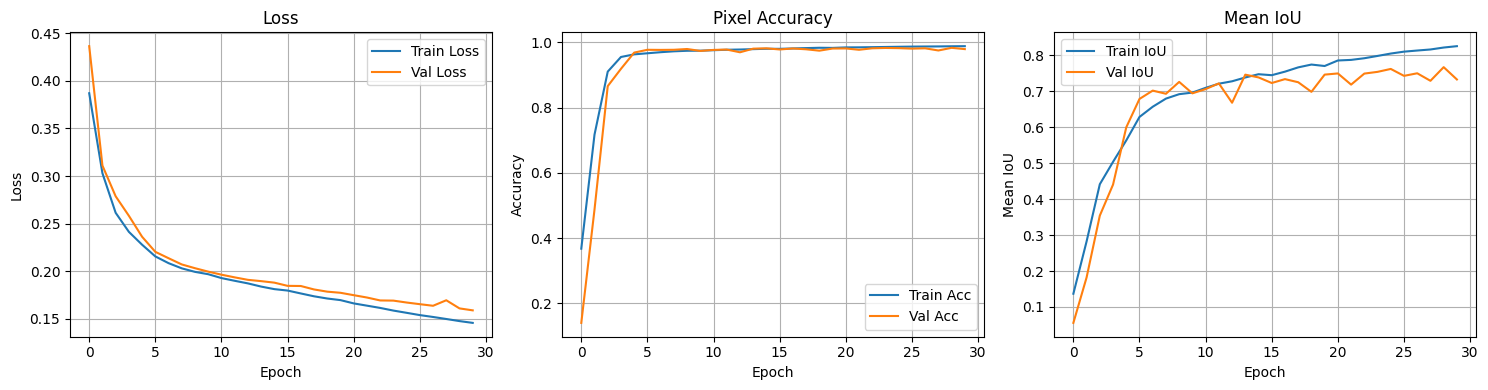

Best Results:
  Best Val IoU: 0.7674
  Best Val Loss: 0.1590


In [20]:
# plotting  training curves
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Loss
axes[0].plot(history.history['loss'], label='Train Loss')
axes[0].plot(history.history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy
axes[1].plot(history.history['accuracy'], label='Train Acc')
axes[1].plot(history.history['val_accuracy'], label='Val Acc')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Pixel Accuracy')
axes[1].legend()
axes[1].grid(True)

# IoU
axes[2].plot(history.history['sparse_mean_io_u'], label='Train IoU')
axes[2].plot(history.history['val_sparse_mean_io_u'], label='Val IoU')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Mean IoU')
axes[2].set_title('Mean IoU ')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.savefig('training_curves_resnet.png', dpi=150)
plt.show()

print(f"Best Results:")
print(f"  Best Val IoU: {max(history.history['val_sparse_mean_io_u']):.4f}")
print(f"  Best Val Loss: {min(history.history['val_loss']):.4f}")

# **7-** **Evaluation based on test data**

In [21]:
# Batch-by-batch prediction
all_preds = []
all_y_true = []

print("Predicting batch by batch...")
for i in range(len(test_gen)):
    X_batch, Y_batch = test_gen[i]
    preds_batch = model.predict(X_batch, verbose=0)
    preds_classes = np.argmax(preds_batch, axis=-1)

    all_preds.append(preds_classes)
    all_y_true.append(Y_batch[..., 0])  # Remove channel dim

    # Cleaning...
    del X_batch, Y_batch, preds_batch
    gc.collect()

preds_classes = np.concatenate(all_preds, axis=0)
y_true = np.concatenate(all_y_true, axis=0)

print(f"✅ Predictions shape: {preds_classes.shape}")
print(f"✅ Ground truth shape: {y_true.shape}")

# Pixel Accuracy
pixel_accuracy = np.mean(preds_classes == y_true)
print(f"\n📊 Pixel Accuracy: {pixel_accuracy:.4f}")

# Per-class IoU
def compute_iou(y_true, y_pred, n_classes):
    ious = []
    for c in range(n_classes):
        yt = (y_true == c).flatten()
        yp = (y_pred == c).flatten()
        inter = np.sum(yt & yp)
        union = np.sum(yt | yp)
        iou = inter / union if union > 0 else float('nan')
        ious.append(iou)
    return ious

ious = compute_iou(y_true, preds_classes, num_classes)
mean_iou = np.nanmean(ious)

print(f"Mean IoU: {mean_iou:.4f}")

print("\nPer-class IoU:")
for i, iou in enumerate(ious):
    status = f"{iou:.4f}" if not np.isnan(iou) else "N/A"
    print(f"  Class {i}: IoU = {status}")

gc.collect()

Predicting batch by batch...
✅ Predictions shape: (215, 256, 256)
✅ Ground truth shape: (215, 256, 256)

📊 Pixel Accuracy: 0.9817
Mean IoU: 0.7527

Per-class IoU:
  Class 0: IoU = 0.9815
  Class 1: IoU = 0.5981
  Class 2: IoU = 0.6786


0

## Displaying prediction results

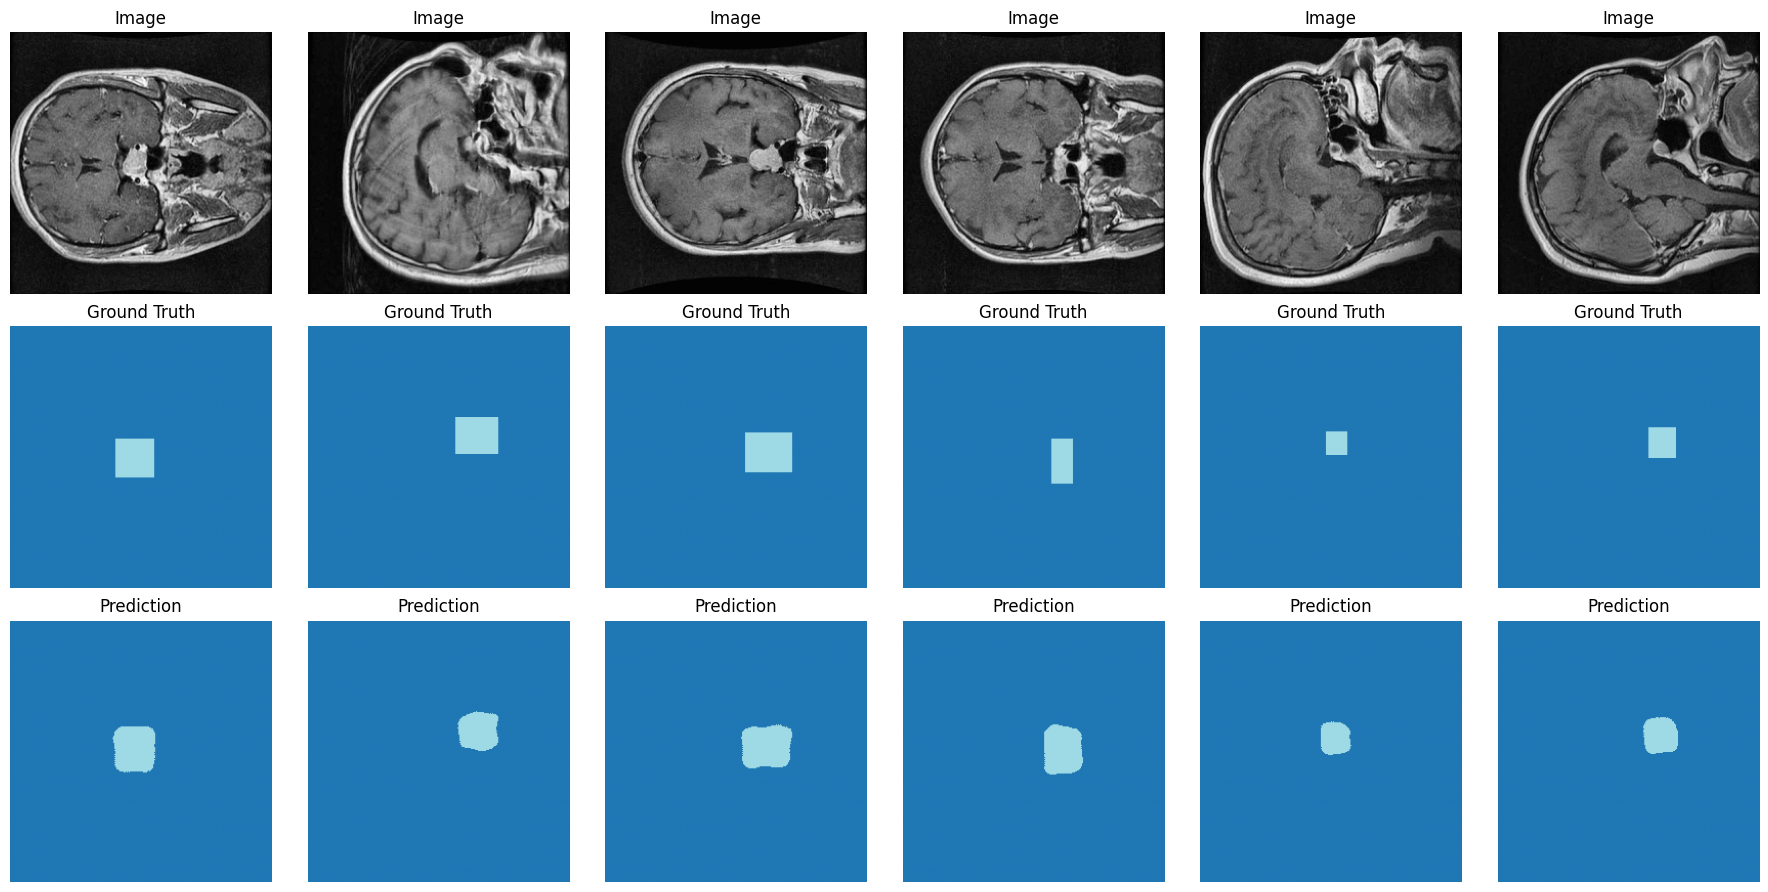

10670

In [22]:
X_sample, Y_sample = test_gen[0]

# reverse preprocessing
# EfficientNet preprocessing apply normalization
sample_images = []
for fn in test_gen.image_files[:BATCH_SIZE]:
    img_path = test_gen.img_dir / fn
    img = cv2.imread(str(img_path))
    img = cv2.resize(img, IMG_SIZE)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    sample_images.append(img)

n_show = min(6, len(sample_images))
fig, axes = plt.subplots(3, n_show, figsize=(3*n_show, 9))

for i in range(n_show):
    # Original image
    axes[0, i].imshow(sample_images[i])
    axes[0, i].set_title('Image')
    axes[0, i].axis('off')

    # Ground truth
    axes[1, i].imshow(Y_sample[i, ..., 0], cmap='tab20', vmin=0, vmax=num_classes-1)
    axes[1, i].set_title('Ground Truth')
    axes[1, i].axis('off')

    # Prediction
    pred = np.argmax(model.predict(X_sample[i:i+1], verbose=0), axis=-1)[0]
    axes[2, i].imshow(pred, cmap='tab20', vmin=0, vmax=num_classes-1)
    axes[2, i].set_title('Prediction')
    axes[2, i].axis('off')

plt.tight_layout()
plt.savefig('predictions_resnet.png', dpi=150)
plt.show()

gc.collect()

# **8-** **Save model**

In [23]:
model.save('brain_segmentation_efficientnet_final.keras')
print("Model saved as 'brain_segmentation_efficientnet_final.keras'")

# Final Summary
print(f"  Model: U-Net with EfficientNetB3")
print(f"  Pretrained: ImageNet")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  " + "-"*40)
print(f"  Pixel Accuracy: {pixel_accuracy:.4f}")
print(f"  Mean IoU: {mean_iou:.4f}")
print(f"  Best Val IoU: {max(history.history['val_sparse_mean_io_u']):.4f}")

Model saved as 'brain_segmentation_efficientnet_final.keras'
  Model: U-Net with EfficientNetB3
  Pretrained: ImageNet
  Learning Rate: 5e-05
  ----------------------------------------
  Pixel Accuracy: 0.9817
  Mean IoU: 0.7527
  Best Val IoU: 0.7674
